In [1]:
import os

plant_clef_root = os.path.dirname(os.getcwd())
os.chdir(plant_clef_root)
print "Set working directory: %s" % plant_clef_root

data_dir = os.path.join(plant_clef_root, 'data')
snapshots_dir = os.path.join(data_dir, 'snapshots')
if not os.path.exists(snapshots_dir):
    !mkdir $snapshots_dir


Set working directory: /home/ffw/workspace/plantCLEF


In [2]:
def snapshot_prefix(id):
    return os.path.join(snapshots_dir, id)

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

#img = np.random.random((32,32,3))
#plt.imshow(img, interpolation='Nearest')
#plt.axis('off');

# Fine-tuning a Pretrained Network for Style Recognition

In this example, we'll explore a common approach that is particularly useful in real-world applications: take a pre-trained Caffe network and fine-tune the parameters on your custom data.

The advantage of this approach is that, since pre-trained networks are learned on a large set of images, the intermediate layers capture the "semantics" of the general visual appearance. Think of it as a very powerful generic visual feature that you can treat as a black box. On top of that, only a relatively small amount of data is needed for good performance on the target task.

First, we will need to prepare the data. This involves the following parts:
1. Get the ImageNet ilsvrc pretrained model with the provided shell scripts.
2. Download a subset of the overall Flickr style dataset for this demo.
3. Compile the downloaded Flickr dataset into a database that Caffe can then consume.

In [4]:
import sys

#caffe_root = '/home/ffw/workspace/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
#sys.path.insert(0, plant_clef_root)

import caffe
from caffe import layers as L
from caffe import params as P

import numpy as np
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
import tempfile

import mcl
import mcl.nets as mcl_nets
import mcl.solvers as mcl_solvers
from utilities import *

In [5]:
nvidia_smi = !whatis nvidia-smi
print nvidia_smi
if 'NVIDIA System Management' in nvidia_smi[0]:
    # Theres is GPU hardware
    print "Set mode to GPU"
    caffe.set_device(0)
    caffe.set_mode_gpu()
else:
    print "Set mode to CPU"
    caffe.set_mode_cpu()

['nvidia-smi (1)       - NVIDIA System Management Interface program']
Set mode to GPU


### 1. Setup and dataset download

Download data required for this exercise.

- `get_ilsvrc_aux.sh` to download the ImageNet data mean, labels, etc.
- `download_model_binary.py` to download the pretrained reference model
- `finetune_flickr_style/assemble_data.py` downloadsd the style training and testing data

We'll download just a small subset of the full dataset for this exercise: just 2000 of the 80K images, from 5 of the 20 style categories.  (To download the full dataset, set `full_dataset = True` in the cell below.)

### 1.1 Fetch pre-trained weights

In [5]:
weights_imagenet = os.path.join(plant_clef_root,'models/bvlc_reference_caffenet.caffemodel')
assert os.path.exists(weights_imagenet)

### 1.2 Get a string representation of the labels
It asserts the labels have an id matching the line number in the file.

In [6]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = os.path.join(plant_clef_root, 'models', 'imagenet_labels.txt')
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:4] + ['...'])

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
...


In [7]:
# Load style labels to style_labels
#style_label_file = caffe_root + 'examples/finetune_flickr_style/style_names.txt'
species_label_file = os.path.join(plant_clef_root, 'data/species.txt')
species_labels = list(np.loadtxt(species_label_file, str, delimiter='\n'))
NUM_SPECIES_LABELS = len(species_labels)
print 'Loaded species labels:\n', '\n'.join(species_labels[:4] + ["..."])

Loaded species labels:
Acer pseudoplatanus L.
Acer saccharinum L.
Carpobrotus edulis (L.) N.E.Br.
Amaranthus deflexus L.
...


In [8]:

def disp_imagenet_preds(net, image):
    disp_predictions(net, image, imagenet_labels, name='ImageNet')

def disp_species_pred(net, image):
    disp_predictions(net, image, species_labels, name='species')    


### 2.  Defining and running the nets

We'll start by defining `caffenet`, a function which initializes the *CaffeNet* architecture (a minor variant on *AlexNet*), taking arguments specifying the data and number of output classes.

Now, let's create a *CaffeNet* that takes unlabeled "dummy data" as input, allowing us to set its input images externally and see what ImageNet classes it predicts.

In [9]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = mcl_nets.caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights_imagenet, caffe.TEST)

In [10]:
train_data_path = os.path.join(plant_clef_root, 'data', 'train.txt')
test_data_path = os.path.join(plant_clef_root, 'data', 'test.txt')

train_net_path = os.path.join(plant_clef_root, 'models', 'train.prototxt')
mcl_nets.speciesnet(train=False, source=train_data_path, output_path=train_net_path)

'/home/ffw/workspace/plantCLEF/models/train.prototxt'

Use the `style_net` function defined above to initialize `untrained_style_net`, a *CaffeNet* with input images from the style dataset and weights from the pretrained ImageNet model.


Call `forward` on `untrained_style_net` to get a batch of style training data.

In [11]:
if 'untrained_species_net' in locals():
    del untrained_species_net
untrained_species_net = caffe.Net(train_net_path, weights_imagenet, caffe.TEST)


untrained_species_net.forward()
species_data_batch = untrained_species_net.blobs['data'].data.copy()
species_label_batch = np.array(untrained_species_net.blobs['label'].data, dtype=np.int32)

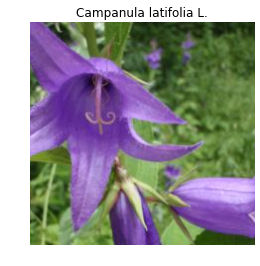

top 5 predicted imagenet labels =
	(1) 16.39% n02236044 mantis, mantid
	(2) 15.11% n02219486 ant, emmet, pismire
	(3)  7.00% n03944341 pinwheel
	(4)  6.97% n04525038 velvet
	(5)  6.20% n02206856 bee

top 5 predicted untrained species net labels =
	(1)  0.10% Acer pseudoplatanus L.
	(2)  0.10% Tractema lilio-hyacinthus (L.) Speta
	(3)  0.10% Tractema verna (Huds.) Speta
	(4)  0.10% Smilax aspera L.
	(5)  0.10% Veratrum album L.


In [12]:
batch_index = 8
image = species_data_batch[batch_index]

plt.imshow(deprocess_net_image(image))
plt.axis('off');
plt.title(species_labels[species_label_batch[batch_index]]);
plt.show()

disp_predictions(imagenet_net, image, imagenet_labels, name='imagenet')
print ""
disp_predictions(untrained_species_net, image, species_labels, name='untrained species net')

We can also verify that the activations in layer `fc7` immediately before the classification layer are the same as (or very close to) those in the ImageNet-pretrained model, since both models are using the same pretrained weights in the `conv1` through `fc7` layers.

In [13]:
diff = untrained_species_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

Delete `untrained_species_net` to save memory.  (Hang on to `imagenet_net` as we'll use it again later.)

In [14]:
if 'untrained_species_net' in locals():
    del untrained_species_net

### 3. Training the style classifier

Let's create and run solvers to train nets for the style recognition task.  We'll create two solvers -- one (`style_solver`) will have its train net initialized to the ImageNet-pretrained weights (this is done by the call to the `copy_from` method), and the other (`scratch_style_solver`) will start from a *randomly* initialized net.

During training, we should see that the ImageNet pretrained net is learning faster and attaining better accuracies than the scratch net.

In [ ]:
niter = 30000  # number of iterations to train

# Reset species_solver as before.
species_solver_filename = mcl_solvers.tutorial(mcl_nets.speciesnet(train=True), 
                                               snapshot_prefix=snapshot_prefix('imagenet'))
species_solver = caffe.get_solver(species_solver_filename)
#species_solver.net.copy_from("/home/ffw/workspace/plantCLEF/models/weights.pretrained.caffemodel")
species_solver.net.copy_from(weights_imagenet)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_species_solver_filename = mcl_solvers.tutorial(mcl_nets.speciesnet(train=True), snapshot_prefix=snapshot_prefix('scratch'))
#scratch_species_solver_filename = solver(species_net(train=True))
scratch_species_solver = caffe.get_solver(scratch_species_solver_filename)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', species_solver),
           ('scratch', scratch_species_solver)]
loss, acc, weights = run_solvers(niter, solvers, disp_interval=100)
print 'Done.'

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
species_weights, scratch_species_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del species_solver, scratch_species_solver, solvers

In [ ]:
for id, weight_path in weights.items():
    !cp $weight_path models/

Let's look at the training loss and accuracy produced by the two training procedures.  Notice how quickly the ImageNet pretrained model's loss value (blue) drops, and that the randomly initialized model's loss value (green) barely (if at all) improves from training only the classifier layer.

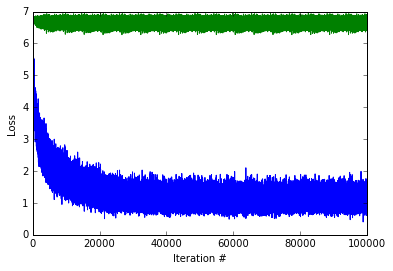

In [40]:
plot(np.vstack([train_loss, scratch_train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

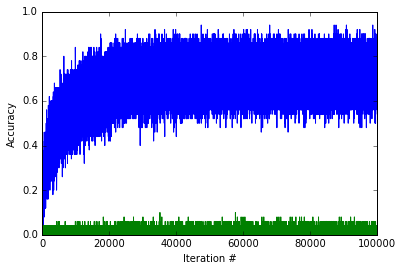

In [41]:
plot(np.vstack([train_acc, scratch_train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

In [44]:
#np.save("data/train_loss.npy", train_loss)
#np.save("data/scratch_train_loss.npy", scratch_train_loss)
#np.save("data/train_acc.npy", train_acc)
#np.save("data/scratch_train_acc.npy", scratch_train_acc)

Let's take a look at the testing accuracy after running 200 iterations of training. Note that we're classifying among 5 classes, giving chance accuracy of 20%. We expect both results to be better than chance accuracy (20%), and we further expect the result from training using the ImageNet pretraining initialization to be much better than the one from training from scratch. Let's see.

In [ ]:
def eval_style_net(weights, test_iters=10):
#    test_net = caffe.Net(style_net(train=False), weights, caffe.TEST)
    test_net = caffe.Net(mcl.nets.speciesnet(train=False), weights, caffe.TEST)
    accuracy = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
    accuracy /= test_iters
    return test_net, accuracy

In [45]:
test_net, accuracy = eval_style_net(style_weights)
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights)

In [46]:
print 'Accuracy, trained from ImageNet initialization: %3.1f%%' % (100*accuracy, )
print 'Accuracy, trained from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, trained from ImageNet initialization: 41.4%
Accuracy, trained from   random initialization: 0.8%


### 4. End-to-end finetuning for style

Finally, we'll train both nets again, starting from the weights we just learned.  The only difference this time is that we'll be learning the weights "end-to-end" by turning on learning in *all* layers of the network, starting from the RGB `conv1` filters directly applied to the input image.  We pass the argument `learn_all=True` to the `style_net` function defined earlier in this notebook, which tells the function to apply a positive (non-zero) `lr_mult` value for all parameters.  Under the default, `learn_all=False`, all parameters in the pretrained layers (`conv1` through `fc7`) are frozen (`lr_mult = 0`), and we learn only the classifier layer `fc8_flickr`.

Note that both networks start at roughly the accuracy achieved at the end of the previous training session, and improve significantly with end-to-end training.  To be more scientific, we'd also want to follow the same additional training procedure *without* the end-to-end training, to ensure that our results aren't better simply because we trained for twice as long.  Feel free to try this yourself!

In [ ]:
#end_to_end_net = style_net(train=True, learn_all=True)
end_to_end_net = mcl.nets.speciesnet(train=True, learn_all=True)

# Set base_lr to 1e-3, the same as last time when learning only the classifier.
# You may want to play around with different values of this or other
# optimization parameters when fine-tuning.  For example, if learning diverges
# (e.g., the loss gets very large or goes to infinity/NaN), you should try
# decreasing base_lr (e.g., to 1e-4, then 1e-5, etc., until you find a value
# for which learning does not diverge).
base_lr = 0.001

style_solver_filename = mcl.solvers.tutorial(end_to_end_net, base_lr=base_lr, snapshot_prefix=snapshot_prefix('imagenet_ft'))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(style_weights)

scratch_style_solver_filename = mcl.solvers.tutorial(end_to_end_net, base_lr=base_lr, snapshot_prefix=snapshot_prefix('scratch_ft'))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)
scratch_style_solver.net.copy_from(scratch_style_weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained, end-to-end', style_solver),
           ('scratch, end-to-end', scratch_style_solver)]
_, _, finetuned_weights = run_solvers(niter, solvers, disp_interval=100)
print 'Done.'

style_weights_ft = finetuned_weights['pretrained, end-to-end']
scratch_style_weights_ft = finetuned_weights['scratch, end-to-end']


# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

Let's now test the end-to-end finetuned models.  Since all layers have been optimized for the style recognition task at hand, we expect both nets to get better results than the ones above, which were achieved by nets with only their classifier layers trained for the style task (on top of either ImageNet pretrained or randomly initialized weights).

In [47]:
test_net, accuracy = eval_style_net(style_weights_ft)
scratch_test_net, scratch_accuracy = eval_style_net(scratch_style_weights_ft)

print 'Accuracy, finetuned from ImageNet initialization: %3.1f%%' % (100*accuracy, )
print 'Accuracy, finetuned from   random initialization: %3.1f%%' % (100*scratch_accuracy, )

Accuracy, finetuned from ImageNet initialization: 54.2%
Accuracy, finetuned from   random initialization: 24.0%


We'll first look back at the image we started with and check our end-to-end trained model's predictions.

In [ ]:
plt.imshow(deprocess_net_image(image))
disp_species_pred(test_net, image)

Whew, that looks a lot better than before!  But note that this image was from the training set, so the net got to see its label at training time.

Finally, we'll pick an image from the test set (an image the model hasn't seen) and look at our end-to-end finetuned style model's predictions for it.

In [ ]:
batch_index = 1
image = test_net.blobs['data'].data[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', species_labels[int(test_net.blobs['label'].data[batch_index])]

In [ ]:
disp_species_pred(test_net, image)

In [ ]:
test_net

We can also look at the predictions of the network trained from scratch.  We see that in this case, the scratch network also predicts the correct label for the image (*Pastel*), but is much less confident in its prediction than the pretrained net.

In [ ]:
disp_species_pred(scratch_test_net, image)

Of course, we can again look at the ImageNet model's predictions for the above image:

In [ ]:
disp_imagenet_preds(imagenet_net, image)

So we did finetuning and it is awesome. Let's take a look at what kind of results we are able to get with a longer, more complete run of the style recognition dataset. Note: the below URL might be occassionally down because it is run on a research machine.

http://demo.vislab.berkeleyvision.org/

# Scratch


In [6]:
weights_test_net = "/home/ffw/workspace/plantCLEF/models/weights.pretrained.caffemodel"
net_proto = "/home/ffw/workspace/plantCLEF/models/train.prototxt"

In [7]:
test_net = caffe.Net(net_proto, weights_test_net, caffe.TEST)

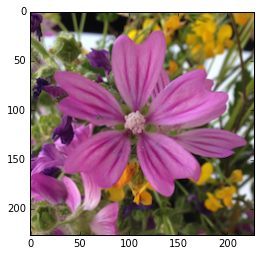

top 5 predicted species labels =
	(1) 77.08% Malva sylvestris L.
	(2)  3.04% Silene dioica (L.) Clairv.
	(3)  2.93% Geranium molle L.
	(4)  2.75% Geranium nodosum L.
	(5)  1.98% Malva arborea (L.) Webb & Berthel.


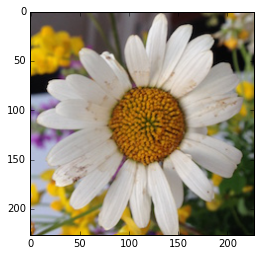

top 5 predicted species labels =
	(1) 43.89% Leucanthemum vulgare Lam.
	(2) 26.45% Matricaria chamomilla L.
	(3) 11.70% Anacyclus clavatus (Desf.) Pers.
	(4)  6.72% Erigeron karvinskianus DC.
	(5)  6.39% Tripleurospermum inodorum Sch.Bip.


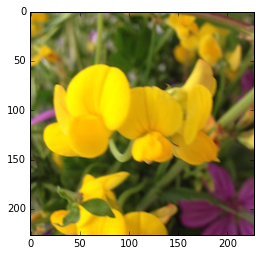

top 5 predicted species labels =
	(1) 22.03% Coronilla glauca L.
	(2) 19.71% Coronilla valentina L.
	(3) 13.87% Lotus corniculatus L.
	(4)  7.61% Hippocrepis comosa L.
	(5)  5.73% Coronilla juncea L.


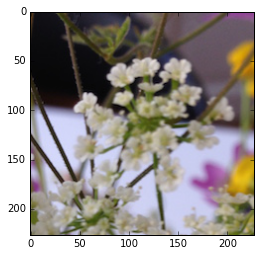

top 5 predicted species labels =
	(1) 11.27% Cornus mas L.
	(2)  5.51% Ilex aquifolium L.
	(3)  4.92% Foeniculum vulgare Mill.
	(4)  3.96% Prunus dulcis (Mill.) D.A.Webb
	(5)  3.89% Olea europaea L.


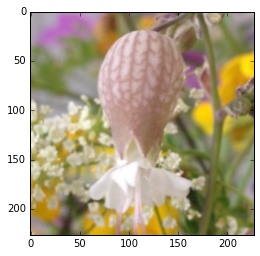

top 5 predicted species labels =
	(1) 11.61% Viola calcarata L.
	(2)  5.85% Glaucium flavum Crantz
	(3)  4.09% Lantana camara L.
	(4)  3.32% Prunus avium (L.) L.
	(5)  3.12% Cistus salviifolius L.


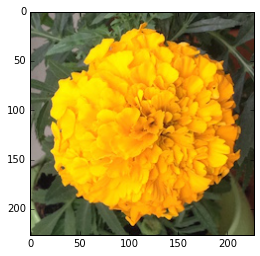

top 5 predicted species labels =
	(1) 47.39% Glaucium flavum Crantz
	(2) 17.25% Opuntia ficus-indica (L.) Mill.
	(3) 10.29% Meconopsis cambrica (L.) Vig.
	(4)  4.78% Kerria japonica (L.) DC.
	(5)  3.03% Achillea filipendulina Lam.


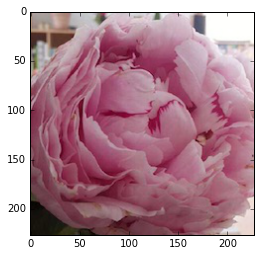

top 5 predicted species labels =
	(1) 66.88% Prunus serrulata Lindl.
	(2)  5.93% Nerium oleander L.
	(3)  5.41% Papaver somniferum L.
	(4)  5.06% Hydrangea macrophylla (Thunb.) Ser.
	(5)  3.93% Cercis siliquastrum L.


In [21]:
images = !ls $plant_clef_root/data/samples
for img_name in images:
    img_path = os.path.join(plant_clef_root, 'data', 'samples', img_name)
    img = imread(img_path)[14:-15,14:-15,:]
    
    figure()
    imshow(img)
    plt.show()
    disp_species_pred(test_net, process_net_image(img))

In [49]:
def vis_square(data):
    """
    Copied from Caffe tutorial 00-classification
    Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

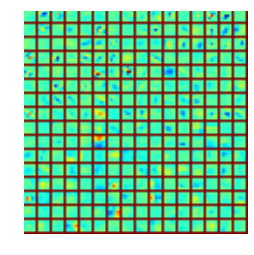

In [50]:
par_conv1 = imagenet_net.params['conv2'][0].data
vis_square(par_conv1.transpose(0, 2, 3, 1)[:,:,:,0])

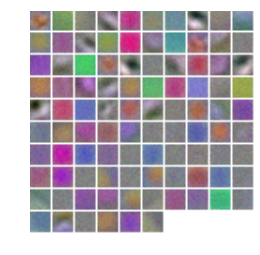

In [51]:
f = scratch_test_net.params['conv1'][0].data
vis_square(f.transpose(0, 2, 3, 1)[:,:,:,::-1])

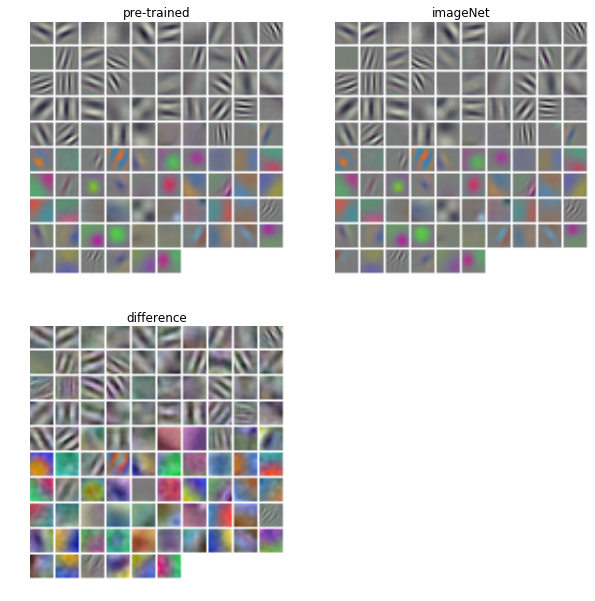

In [52]:
f1 = test_net.params['conv1'][0].data
f2 = imagenet_net.params['conv1'][0].data
f3 = f1-f2


figure(figsize=(10,10))
subplot(2,2,1)
title('pre-trained')
vis_square(f1.transpose(0, 2, 3, 1)[:,:,:,::-1])
subplot(2,2,2)
title('imageNet')
vis_square(f2.transpose(0, 2, 3, 1)[:,:,:,::-1])
subplot(2,2,3)
title('difference')
vis_square(f3[:,:,:,:].transpose(0, 2, 3, 1)[:,:,:,::-1])


In [59]:
print "Scratch"
print "f^2:  %10.3f" % np.sum(f**2)
print "Transfer"
print "f1^2: %10.3f" % np.sum(f1**2)
print "f2^2: %10.3f" % np.sum(f2**2)
print "f3^2: %10.3f" % np.sum(f3**2)

Scratch
f^2:      38.342
Transfer
f1^2:    149.601
f2^2:    124.041
f3^2:      4.480


In [ ]:
print "\n".join(["%s: %s"%(k, str(v.data.shape)) for k, v in test_net.blobs.items()])